In [ ]:
pip install pandas_profiling

In [ ]:
pip install unidecode

In [12]:
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import unidecode
import seaborn as sns
import requests
import zipfile
import io
import os
import glob

In [20]:
def generate_url(base_url, year, additional_info=""):
    return f'{base_url}_{year}{additional_info}.zip'

def create_urls(base_url, years, additional_info=""):
    return {year: generate_url(base_url, year, additional_info) for year in years}

# URLs dos arquivos de votação por seção
votacao_base_url = 'https://cdn.tse.jus.br/estatistica/sead/odsele/votacao_secao/votacao_secao'
votacao_years = [2020, 2016, 2012, 2008, 2004, 2000]
votacao_urls = create_urls(votacao_base_url, votacao_years, "_PR")

# URLs dos arquivos de bens do candidato
bem_candidato_base_url = 'https://cdn.tse.jus.br/estatistica/sead/odsele/bem_candidato/bem_candidato'
bem_candidato_years = [2020, 2016, 2012, 2008]
bem_candidato_urls = create_urls(bem_candidato_base_url, bem_candidato_years)

print("URLs de votação por seção:")
for year, url in votacao_urls.items():
    print(f'{year}: {url}')

print("\nURLs de bens do candidato:")
for year, url in bem_candidato_urls.items():
    print(f'{year}: {url}')

URLs de votação por seção:
2020: https://cdn.tse.jus.br/estatistica/sead/odsele/votacao_secao/votacao_secao_2020_PR.zip
2016: https://cdn.tse.jus.br/estatistica/sead/odsele/votacao_secao/votacao_secao_2016_PR.zip
2012: https://cdn.tse.jus.br/estatistica/sead/odsele/votacao_secao/votacao_secao_2012_PR.zip
2008: https://cdn.tse.jus.br/estatistica/sead/odsele/votacao_secao/votacao_secao_2008_PR.zip
2004: https://cdn.tse.jus.br/estatistica/sead/odsele/votacao_secao/votacao_secao_2004_PR.zip
2000: https://cdn.tse.jus.br/estatistica/sead/odsele/votacao_secao/votacao_secao_2000_PR.zip

URLs de bens do candidato:
2020: https://cdn.tse.jus.br/estatistica/sead/odsele/bem_candidato/bem_candidato_2020.zip
2016: https://cdn.tse.jus.br/estatistica/sead/odsele/bem_candidato/bem_candidato_2016.zip
2012: https://cdn.tse.jus.br/estatistica/sead/odsele/bem_candidato/bem_candidato_2012.zip
2008: https://cdn.tse.jus.br/estatistica/sead/odsele/bem_candidato/bem_candidato_2008.zip
2004: https://cdn.tse.jus.b

In [21]:
# Pasta de destino
output_folder = 'extracao'

# Criar a pasta se não existir
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Função para baixar e extrair os arquivos
def download_and_extract(url, output_folder, filter_extension=None):
    response = requests.get(url)

    # Verificar se a requisição foi bem-sucedida
    if response.status_code == 200:
        try:
            with zipfile.ZipFile(io.BytesIO(response.content)) as z:
                # Iterar sobre os arquivos no ZIP
                for file in z.namelist():
                    file_path = os.path.join(output_folder, file)

                    # Verificar a extensão do arquivo se um filtro for fornecido
                    if filter_extension and not file.endswith(filter_extension):
                        continue

                    # Verificar se o arquivo já existe na pasta de destino
                    if not os.path.exists(file_path):
                        # Extrair o arquivo mantendo seu nome original
                        with z.open(file) as source, open(file_path, 'wb') as dest:
                            dest.write(source.read())
                        print(f"Arquivo {file} extraído para {output_folder}")
                    else:
                        print(f"Arquivo {file} já existe em {output_folder}. Pulando o download.")
        except zipfile.BadZipFile:
            print(f"Erro: O conteúdo de {url} não é um arquivo ZIP válido.")
        except Exception as e:
            print(f"Erro ao extrair arquivos. Erro: {e}")
    else:
        print(f"Erro: Falha na requisição para {url}. Status code: {response.status_code}")

# Obter o caminho absoluto para a pasta de destino
absolute_output_folder = os.path.join(os.getcwd(), output_folder)

# Iterar sobre as URLs de votação por seção e baixar/extrair os arquivos .csv com "PR" no final
for year, url in votacao_urls.items():
    print(f"Baixando e extraindo dados de votação de {year} para {absolute_output_folder}...")
    download_and_extract(url, absolute_output_folder, filter_extension="PR.csv")

# Iterar sobre as URLs de bens do candidato e baixar/extrair os arquivos .csv com "PR" no final
for year, url in bem_candidato_urls.items():
    print(f"Baixando e extraindo dados de bens do candidato de {year} para {absolute_output_folder}...")
    download_and_extract(url, absolute_output_folder, filter_extension="PR.csv")

Baixando e extraindo dados de votação de 2020 para /home/crislaine/GitProjects/eleicoes/extracao...
Arquivo votacao_secao_2020_PR.csv já existe em /home/crislaine/GitProjects/eleicoes/extracao. Pulando o download.
Baixando e extraindo dados de votação de 2016 para /home/crislaine/GitProjects/eleicoes/extracao...
Arquivo votacao_secao_2016_PR.csv já existe em /home/crislaine/GitProjects/eleicoes/extracao. Pulando o download.
Baixando e extraindo dados de votação de 2012 para /home/crislaine/GitProjects/eleicoes/extracao...
Arquivo votacao_secao_2012_PR.csv já existe em /home/crislaine/GitProjects/eleicoes/extracao. Pulando o download.
Baixando e extraindo dados de votação de 2008 para /home/crislaine/GitProjects/eleicoes/extracao...
Arquivo votacao_secao_2008_PR.csv já existe em /home/crislaine/GitProjects/eleicoes/extracao. Pulando o download.
Baixando e extraindo dados de votação de 2004 para /home/crislaine/GitProjects/eleicoes/extracao...
Arquivo votacao_secao_2004_PR.csv já existe 

In [33]:
# Função que extrai e processa os dados

def load_and_process_data(path, years, municipio, columns, prefix):
    dfs = {}  # Dicionário para armazenar os DataFrames correspondentes a cada ano

    for year in years:
        # Construção do nome do arquivo a ser carregado
        filename = f'{prefix}_{year}_PR.csv'
        delimiter = ';'
        file_path = absolute_output_folder

        # Verificar se o arquivo já existe antes de tentar carregar
        if not os.path.exists(file_path):
            print(f"Arquivo para o ano {year} e prefixo {prefix} não encontrado em {path}. Pulando o carregamento.")
            continue

        try:
            # Carregamento do DataFrame a partir do arquivo CSV
            df = pd.read_csv(file_path, encoding='latin-1', on_bad_lines='skip', delimiter=delimiter)

            # Filtro para manter apenas os registros relacionados ao município especificado
            df = df[df['NM_MUNICIPIO'] == municipio]

            # Verificação das colunas existentes no DataFrame carregado
            existing_columns = set(df.columns)

            # Filtragem das colunas desejadas, mantendo apenas as presentes no DataFrame
            columns_to_filter = [col for col in columns if col in existing_columns]

            # Atualização do DataFrame com as colunas filtradas
            if columns_to_filter:
                df = df[columns_to_filter]
                key = f"{prefix}_{year}"  # Use um formato de chave que identifique o DataFrame
                dfs[key] = df
                print(f"DataFrame carregado com sucesso para o ano {year} e prefixo {prefix}. Nome do DataFrame: dfs['{key}']")
            else:
                print(f"Não existem as colunas especificadas para o Dataframe em {year} e prefixo {prefix}")
        except Exception as e:
            print(f"Erro ao carregar o DataFrame para o ano {year} e prefixo {prefix}. Erro: {e}")

    return dfs

In [36]:
absolute_output_folder

'/home/crislaine/GitProjects/eleicoes/extracao'

In [34]:
# Carregando dados do Município

prefix = 'votacao_secao'
file_path = glob.glob(os.path.join(absolute_output_folder, f'{prefix}_*.csv'))
years = [2000, 2004, 2008, 2012, 2016, 2020]
municipio = 'PIRAQUARA'
columns = ['ANO_ELEICAO', 'DS_CARGO', 'NR_VOTAVEL', 'NR_SECAO', 'QT_VOTOS', 'NR_VOTAVEL', 
           'NM_VOTAVEL', 'NR_LOCAL_VOTACAO', 'NM_LOCAL_VOTACAO', 'DS_LOCAL_VOTACAO_ENDERECO']

df_v_final = load_and_process_data(path, years, municipio, columns, prefix)

TypeError: stat: path should be string, bytes, os.PathLike or integer, not list

In [35]:
file_path

['/home/crislaine/GitProjects/eleicoes/extracao/votacao_secao_2020_PR.csv',
 '/home/crislaine/GitProjects/eleicoes/extracao/votacao_secao_2000_PR.csv',
 '/home/crislaine/GitProjects/eleicoes/extracao/votacao_secao_2012_PR.csv',
 '/home/crislaine/GitProjects/eleicoes/extracao/votacao_secao_2004_PR.csv',
 '/home/crislaine/GitProjects/eleicoes/extracao/votacao_secao_2016_PR.csv',
 '/home/crislaine/GitProjects/eleicoes/extracao/votacao_secao_2008_PR.csv']

In [ ]:
# Carregando dados dos candidatos

path = glob.glob(os.path.join(absolute_output_folder, 'bem_candidato*.csv'))
years = [2008, 2012, 2016, 2020]
prefix = 'bem_candidato'
municipio = 'PIRAQUARA'
columns = ['ANO_ELEICAO', 'DS_CARGO', 'NR_VOTAVEL', 'NR_SECAO', 'QT_VOTOS', 'NR_VOTAVEL', 
           'NM_VOTAVEL', 'NR_LOCAL_VOTACAO', 'NM_LOCAL_VOTACAO', 'DS_LOCAL_VOTACAO_ENDERECO']

df_b_final = load_and_process_data(path, years, municipio, columns, prefix)

In [15]:
# Função para gerar perfil dos dados


def generate_profile_report(dfs, year, cargo):
    # Obtenção do DataFrame correspondente ao ano
    df = df_final.get(year)

    # Verificação se o DataFrame existe e não está vazio para o cargo específico
    if df is not None and not df[(df["DS_CARGO"] == cargo)].empty:
        # Filtragem do DataFrame para o cargo específico
        df_filtered = df[df["DS_CARGO"].str.lower() == cargo.lower()]
        # Agrupamento por candidato e soma dos votos
        df_grouped = df_filtered.groupby("NM_VOTAVEL")["QT_VOTOS"].sum().reset_index()
        # Ordenação por quantidade de votos
        df_sorted = df_grouped.sort_values(by="QT_VOTOS", ascending=False)
        # Geração do perfil de dados
        profile = ProfileReport(df_sorted, title=f"Piraquara - {cargo} {year}")
        # Salvar perfil em um arquivo HTML
        profile.to_file(f"Piraquara - {cargo} {year}.html")
    else:
        print(f"No data found for the year {year} and cargo {cargo}.")


# Exemplo de uso da função para gerar perfis de dados
selected_year = 2020
generate_profile_report(df_final, selected_year, "Prefeito")
generate_profile_report(df_final, selected_year, "Vereador")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 556.35it/s]


In [16]:
# Função que plota os candidatos em um gráfico de barras

def plot_top_candidates(df, cargo, top_n, include_branco_nulo=True, include_partidos=True):
    df_filtered = df[df['DS_CARGO'].str.lower() == cargo.lower()]

    if not include_branco_nulo:
        df_filtered = df_filtered[~df_filtered['NM_VOTAVEL'].isin(['VOTO BRANCO', 'VOTO NULO'])]

    if not include_partidos:
        df_filtered = df_filtered[
            ~((df_filtered['NM_VOTAVEL'].str.lower().str.contains('partido', na=False)) |
              (df_filtered['NM_VOTAVEL'].str.len() <= 5))
        ]

    df_grouped = df_filtered.groupby('NM_VOTAVEL')['QT_VOTOS'].sum().reset_index()
    df_sorted = df_grouped.sort_values(by='QT_VOTOS', ascending=False)
    top_candidates = df_sorted.head(top_n)

    plt.figure(figsize=(12, 8))
    bars = plt.bar(top_candidates['NM_VOTAVEL'], top_candidates['QT_VOTOS'], color='skyblue')
    plt.title(f'Top {top_n} - Votos para {cargo} em Piraquara')
    plt.xlabel('Candidatos')
    plt.ylabel('Total Votos')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 100, round(yval), ha='center', va='bottom', color='black',
                 fontsize=8)

    plt.show()


# Função que plota os votos do partido

def plot_votes_by_partido(df, selected_year):
    df_filtered = df[df['ANO_ELEICAO'] == selected_year]
    df_grouped = df_filtered.groupby('NM_VOTAVEL')['QT_VOTOS'].sum().reset_index()

    df_grouped = df_grouped[
        (df_grouped['NM_VOTAVEL'].str.lower().str.startswith('partido', na=False)) |
        (df_grouped['NM_VOTAVEL'].str.len() <= 5)
    ]

    plt.figure(figsize=(12, 8))
    bars = plt.bar(df_grouped['NM_VOTAVEL'], df_grouped['QT_VOTOS'], color='skyblue')
    plt.title(f'Votos por Partido - {selected_year}')
    plt.xlabel('Partidos')
    plt.ylabel('Total Votos')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 100, round(yval), ha='center', va='bottom', color='black',
                 fontsize=8)

    plt.show()


# Função que plota a evolução dos candidatos

def plot_timeline_all_years(dfs, selected_candidato):
    # Convertendo o nome do candidato para minúsculas e removendo acentos
    selected_candidato = unidecode.unidecode(selected_candidato.lower())

    # Lista para armazenar os resultados de cada DataFrame
    resultados = []

    # Iterando sobre os DataFrames
    for year, df in dfs.items():
        # Filtragem dos registros com base no nome do candidato
        mask = df['NM_VOTAVEL'].str.lower().str.contains(selected_candidato)
        df_filtered = df[mask].copy()  # Criando uma cópia usando o método copy

        # Verificando se há registros correspondentes
        if not df_filtered.empty:
            # Preenchendo valores ausentes com zero na coluna 'QT_VOTOS' usando .loc
            df_filtered.loc[:, 'QT_VOTOS'] = df_filtered['QT_VOTOS'].fillna(0).astype(int)

            # Iterando sobre os candidatos encontrados
            for _, row in df_filtered.iterrows():
                # Somando o total de votos para cada candidato nos anos
                total_votos = row['QT_VOTOS']
                nome_candidato = row['NM_VOTAVEL']

                # Adicionando o resultado à lista
                resultados.append((year, total_votos, nome_candidato))

    if not resultados:
        print(f"Nenhum registro encontrado para o candidato: {selected_candidato}")
        return

    # Criando DataFrame para facilitar o plot
    df_plot = pd.DataFrame(resultados, columns=['Ano', 'Votos', 'Nome'])

    # Agrupando por Nome e Ano e somando os votos
    df_plot = df_plot.groupby(['Nome', 'Ano'])['Votos'].sum().reset_index()

    # Plotando o gráfico de barras
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x='Ano', y='Votos', hue='Nome', data=df_plot, palette='viridis')
    plt.title(f'Total de Votos ao Longo dos Anos para Candidatos - {selected_candidato}')
    plt.xlabel('Ano da Eleição')
    plt.ylabel('Total Votos')
    plt.tight_layout()
    plt.grid(True)

    # Adição de rótulos com os totais de votos sobre as barras
    for p in ax.patches:
        if pd.notna(p.get_height()):  # Verificando se o valor não é NaN
            ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', fontsize=8, color='black', xytext=(0, 10),
                        textcoords='offset points')

    plt.show()

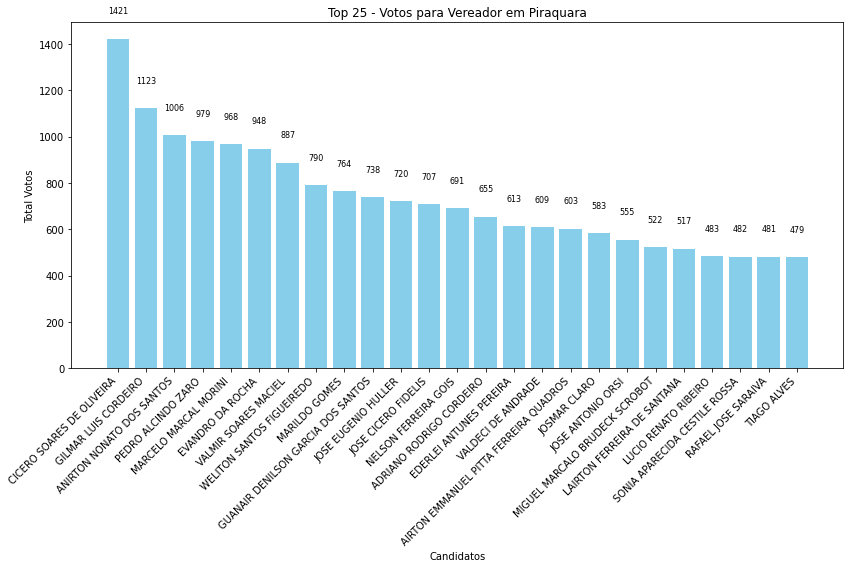

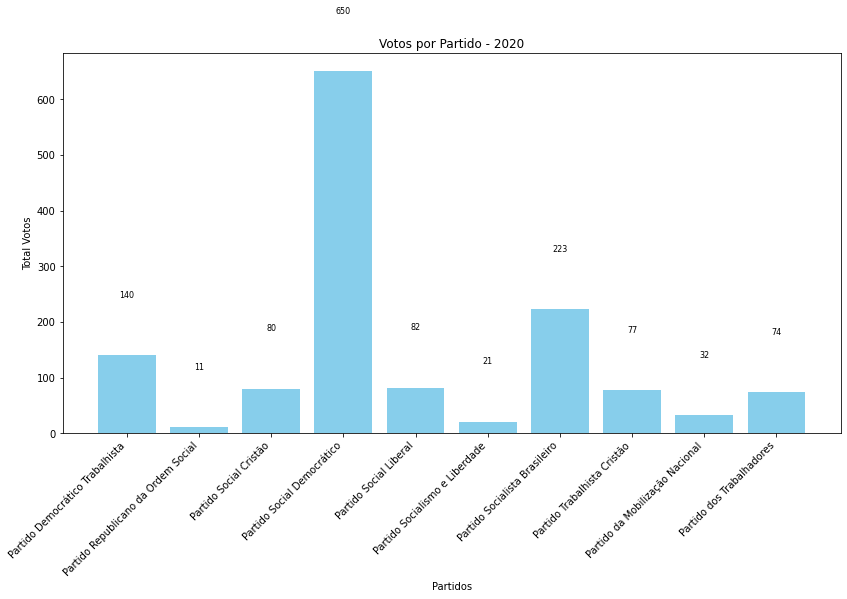

In [18]:
# Ano da Eleição
selected_year = 2020

# Cargo (Vereador ou Prefeito)
selected_cargo = 'Vereador'

# Quantidade de Candidatos
top_n_candidates = 25

# Incluir Votos Brancos e Nulos? 
include_branco_nulo = False

# Incluir votos no Partido?
include_partidos = False

# Chamada da função
plot_top_candidates(df_final[selected_year], selected_cargo, top_n_candidates, include_branco_nulo, include_partidos)
plot_votes_by_partido(df_final[selected_year], selected_year)

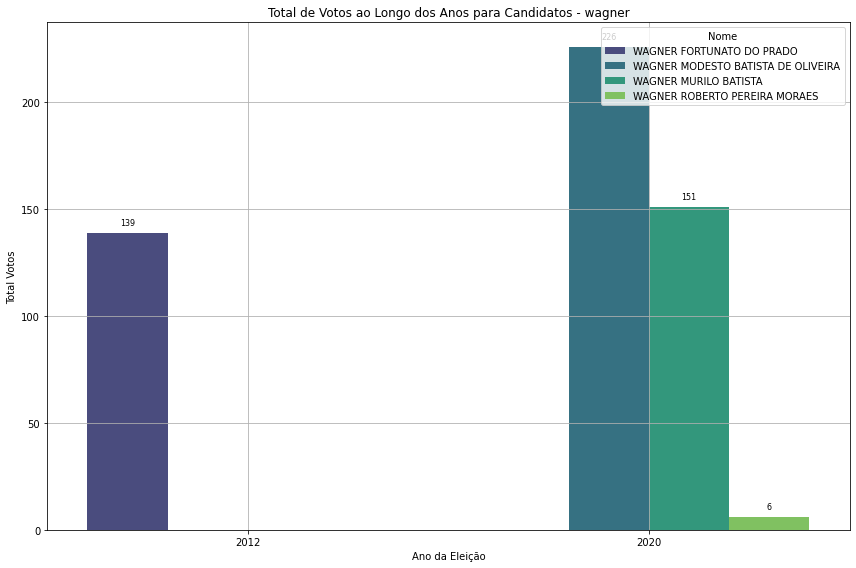

In [19]:
# Nome do Candidato
selected_candidato = 'Wagner'

plot_timeline_all_years(df_final, selected_candidato)